In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain.sim_models_new import Toy_intensity_Generator
import torch
import torch.optim as optim

import paths
from os.path import join

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import simtrain.utils as utils



In [2]:

state_size = SETTINGS.STATE_SIZE
experiment_name = "toy"
#num_negatives = 100
#conditioned=True
#kl_weight=.01

In [3]:
# parameter dicts
width= 8
user_state_dict = {"model_hyp": {"layer_width": [width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
gen_model = Toy_intensity_Generator(hyperparameter_dict)

In [4]:
path = join(paths.dat, SETTINGS.filepaths_new["simulate_intensity_model"]
            )
path

'/home/thahit/github/Recommender_Sim/dat/saved_models_polimi/simulate_intensity/gnerator_model.h5'

In [5]:
#torch.save(gen_model.state_dict(), path)
gen_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [6]:
state = torch.zeros((1, state_size))

In [7]:
samples = [gen_model.sample_one(state).detach().numpy() for _ in range(200)]
samples = np.array(samples)
samples

u: tensor([0.2537]) 	 h: tensor([[2.0000]], grad_fn=<AddBackward0>)
u: tensor([0.6157]) 	 h: tensor([[0.7100]], grad_fn=<AddBackward0>)
u: tensor([0.6221]) 	 h: tensor([[0.7000]], grad_fn=<AddBackward0>)
u: tensor([0.3997]) 	 h: tensor([[1.3400]], grad_fn=<AddBackward0>)
u: tensor([0.4786]) 	 h: tensor([[1.0800]], grad_fn=<AddBackward0>)
u: tensor([0.2859]) 	 h: tensor([[1.8300]], grad_fn=<AddBackward0>)
u: tensor([0.1825]) 	 h: tensor([[2.4700]], grad_fn=<AddBackward0>)
u: tensor([0.7544]) 	 h: tensor([[0.4200]], grad_fn=<AddBackward0>)
u: tensor([0.6061]) 	 h: tensor([[0.7400]], grad_fn=<AddBackward0>)
u: tensor([0.9517]) 	 h: tensor([[0.0800]], grad_fn=<AddBackward0>)
u: tensor([0.6011]) 	 h: tensor([[0.7500]], grad_fn=<AddBackward0>)
u: tensor([0.2439]) 	 h: tensor([[2.0500]], grad_fn=<AddBackward0>)
u: tensor([0.8845]) 	 h: tensor([[0.1800]], grad_fn=<AddBackward0>)
u: tensor([0.2841]) 	 h: tensor([[1.8300]], grad_fn=<AddBackward0>)
u: tensor([0.5590]) 	 h: tensor([[0.8500]], grad

array([[1.9999985 ],
       [0.7099996 ],
       [0.69999963],
       [1.3399991 ],
       [1.0799993 ],
       [1.8299986 ],
       [2.4699981 ],
       [0.41999987],
       [0.7399996 ],
       [0.07999999],
       [0.7499996 ],
       [2.0499985 ],
       [0.18      ],
       [1.8299986 ],
       [0.8499995 ],
       [0.36999992],
       [1.9599985 ],
       [0.9699994 ],
       [0.27      ],
       [0.04      ],
       [5.290026  ],
       [2.2699983 ],
       [1.5999988 ],
       [0.97999936],
       [0.14999999],
       [1.1099993 ],
       [0.86999947],
       [2.1899984 ],
       [0.57999974],
       [0.56999975],
       [0.30999997],
       [0.9699994 ],
       [3.3099973 ],
       [0.32999995],
       [0.67999965],
       [1.409999  ],
       [1.0599993 ],
       [1.439999  ],
       [0.57999974],
       [0.3999999 ],
       [6.0800443 ],
       [1.2999991 ],
       [0.46999982],
       [1.9799985 ],
       [0.5499998 ],
       [0.31999996],
       [0.29      ],
       [0.379

feed in true values for fake models, 


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  if sys.path[0] == "":


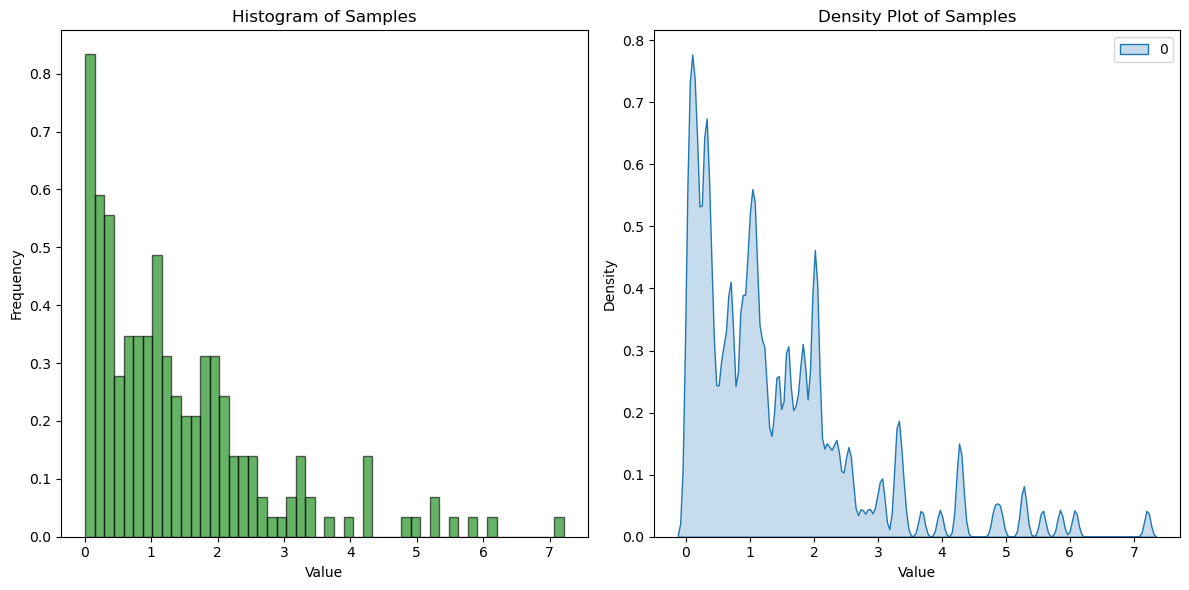

In [8]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)
plt.title('Density Plot of Samples')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [17]:
sample_path = gen_model.sample_path(num_samples=5)
sample_path

u: tensor([0.7982]) 	 h: tensor([[0.3300]])
u: tensor([0.9964]) 	 h: tensor([[0.0100]])
u: tensor([0.6660]) 	 h: tensor([[0.6000]])
u: tensor([0.2352]) 	 h: tensor([[2.0800]])
u: tensor([0.7427]) 	 h: tensor([[0.4200]])


array([[0.32999995],
       [0.33999994],
       [0.9399997 ],
       [3.019998  ],
       [3.439998  ]], dtype=float32)

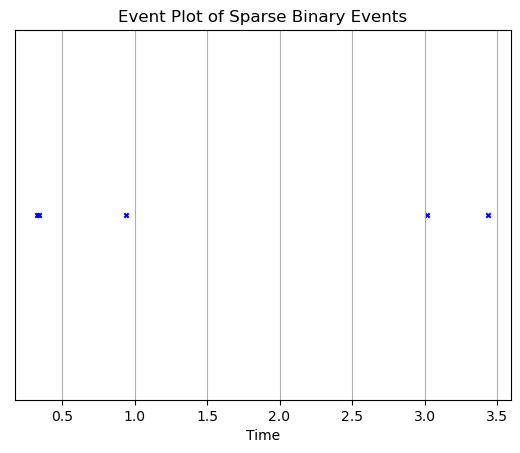

In [18]:
#plt.eventplot(sample_path, orientation='vertical', colors='r')
plt.scatter(sample_path, [1] * len(sample_path), color='blue', label='Time Series 1', s=10, marker='x')

plt.yticks([])
plt.xlabel('Time')
plt.title('Event Plot of Sparse Binary Events')
plt.grid(True)
plt.show()


In [19]:
from tqdm import tqdm
def train_single(model, path, scoring_func,optimizer, num_epochs=100, num_tries=20):
    
    for iter in tqdm(range(num_epochs)):
        last_t = 0
        state = torch.zeros((1, state_size))
        loss = 0.
        #results = []
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                current_pred.append(last_t + model.sample_one(state))
            current_pred = torch.stack(current_pred)
            #results.append(torch.mean(current_pred))
            loss += scoring_func(current_pred, timestep)
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
        print("loss: ", loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
        optimizer.step()

        for name, param in model.named_parameters():
            print(f"Parameter Name: {name}")
        #    print(f"Parameter Value: {param}")
            print(f"Gradients: {param.grad}")
        #    print(f"Parameter Shape: {param.shape}")
        #    print(f"Requires Gradient: {param.requires_grad}")
            print("-" * 40)
        return
        optimizer.zero_grad()

        #return results
        
        #loss calculation

In [20]:
# parameter dicts
width= 8
user_state_dict = {"model_hyp": {"layer_width": [width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
train_model = Toy_intensity_Generator(hyperparameter_dict)

In [21]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(gen_model.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))

In [22]:
sample_path = torch.as_tensor(sample_path)
optimizer = optim.AdamW(train_model.parameters(), lr=0.001,
                        weight_decay=1e-7)


In [15]:
train_single(train_model, sample_path, scoring_func=utils.energy_score_loss,
            optimizer=optimizer, num_epochs=30, num_tries=10)

  0%|          | 0/30 [00:00<?, ?it/s]

u: tensor([0.3428]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.5339]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.6982]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.9331]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.1572]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.8452]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.5371]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.0134]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.4906]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.9031]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.6845]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.3851]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.3712]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.4424]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.8625]) 	 h: tensor([[

  0%|          | 0/30 [00:57<?, ?it/s]

Parameter Name: user_state_model.ode_func.model.0.weight
Gradients: None
----------------------------------------
Parameter Name: user_state_model.ode_func.model.0.bias
Gradients: None
----------------------------------------
Parameter Name: user_state_model.ode_func.model.2.weight
Gradients: None
----------------------------------------
Parameter Name: user_state_model.ode_func.model.2.bias
Gradients: None
----------------------------------------
Parameter Name: user_state_model.ode_func.model.4.weight
Gradients: None
----------------------------------------
Parameter Name: user_state_model.ode_func.model.4.bias
Gradients: None
----------------------------------------
Parameter Name: intensity_model.ode.model.0.weight
Gradients: None
----------------------------------------
Parameter Name: intensity_model.ode.model.0.bias
Gradients: None
----------------------------------------
Parameter Name: intensity_model.ode.model.2.weight
Gradients: None
----------------------------------------


In [16]:
asfawfe

NameError: name 'asfawfe' is not defined

In [ ]:
'''
import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.as_tensor(results).detach().numpy()  # Timestamps for the second time series

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Time Series 1', s=100, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Time Series 2', s=100, marker='x')

# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2])
ax.set_yticklabels(['Time Series 1', 'Time Series 2'])
ax.set_title('Comparison of Two Time Series')
ax.legend()
ax.grid(True)

# Display the plot
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\n# Example data: replace these with your actual time series data\ntime_series_1 = sample_path # Timestamps for the first time series\ntime_series_2 = torch.as_tensor(results).detach().numpy()  # Timestamps for the second time series\n\n# Create a figure and axis\nfig, ax = plt.subplots(figsize=(10, 6))\n\n# Plot the first time series\nax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Time Series 1', s=100, marker='o')\n\n# Plot the second time series\nax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Time Series 2', s=100, marker='x')\n\n# Add labels, legend, and grid\nax.set_xlabel('Time')\nax.set_yticks([1, 2])\nax.set_yticklabels(['Time Series 1', 'Time Series 2'])\nax.set_title('Comparison of Two Time Series')\nax.legend()\nax.grid(True)\n\n# Display the plot\nplt.show()\n"

In [ ]:
state = torch.zeros((1, state_size))
samples = [train_model.sample_one(state).detach().numpy() for _ in range(100)]
samples = np.array(samples)

u: tensor([0.9565]) 	 h: tensor([[0.0200]], grad_fn=<AddBackward0>)
u: tensor([0.8619]) 	 h: tensor([[0.0600]], grad_fn=<AddBackward0>)
u: tensor([0.0470]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.2447]) 	 h: tensor([[9.2101]], grad_fn=<AddBackward0>)
u: tensor([0.3120]) 	 h: tensor([[0.5900]], grad_fn=<AddBackward0>)
u: tensor([0.8404]) 	 h: tensor([[0.0700]], grad_fn=<AddBackward0>)
u: tensor([0.6431]) 	 h: tensor([[0.1900]], grad_fn=<AddBackward0>)
u: tensor([0.1453]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.7877]) 	 h: tensor([[0.1000]], grad_fn=<AddBackward0>)
u: tensor([0.6120]) 	 h: tensor([[0.2100]], grad_fn=<AddBackward0>)
u: tensor([0.6766]) 	 h: tensor([[0.1700]], grad_fn=<AddBackward0>)
u: tensor([0.2010]) 	 h: tensor([[16.9603]], grad_fn=<AddBackward0>)
u: tensor([0.8260]) 	 h: tensor([[0.0800]], grad_fn=<AddBackward0>)
u: tensor([0.0520]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.8644]) 	 h: tensor([[0.0600]], 

/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  if sys.path[0] == "":


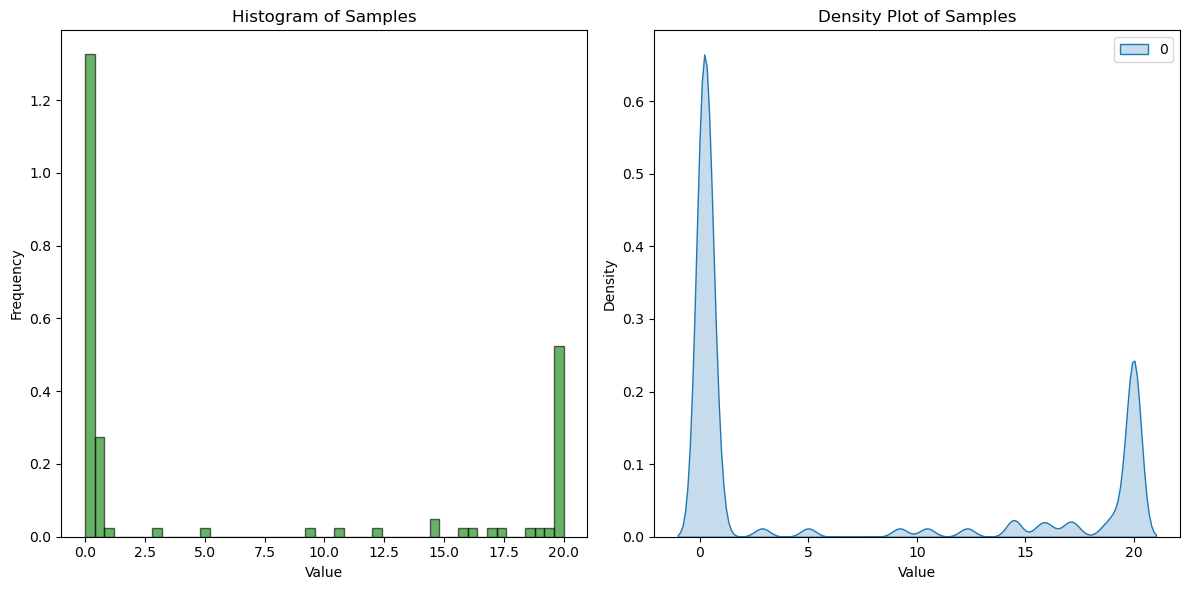

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)
plt.title('Density Plot of Samples')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [ ]:
sample_paths = [torch.as_tensor(gen_model.sample_path(num_samples=7 + i%10)) for i in range(100)]

u: tensor([0.8357]) 	 h: tensor([[0.2700]])
u: tensor([0.8101]) 	 h: tensor([[0.3100]])
u: tensor([0.2139]) 	 h: tensor([[2.2300]])
u: tensor([0.1892]) 	 h: tensor([[2.2800]])
u: tensor([0.1829]) 	 h: tensor([[2.1500]])
u: tensor([0.4126]) 	 h: tensor([[1.0600]])
u: tensor([0.3895]) 	 h: tensor([[1.0800]])
u: tensor([0.4360]) 	 h: tensor([[1.2200]])
u: tensor([0.1618]) 	 h: tensor([[2.5900]])
u: tensor([0.8804]) 	 h: tensor([[0.1800]])
u: tensor([0.6596]) 	 h: tensor([[0.5700]])
u: tensor([0.6600]) 	 h: tensor([[0.5600]])
u: tensor([0.5202]) 	 h: tensor([[0.8500]])
u: tensor([0.7351]) 	 h: tensor([[0.3900]])
u: tensor([0.6919]) 	 h: tensor([[0.4600]])
u: tensor([0.3750]) 	 h: tensor([[1.4300]])
u: tensor([0.3858]) 	 h: tensor([[1.3700]])
u: tensor([0.7856]) 	 h: tensor([[0.3400]])
u: tensor([0.2851]) 	 h: tensor([[1.7200]])
u: tensor([0.9356]) 	 h: tensor([[0.0900]])
u: tensor([0.3759]) 	 h: tensor([[1.2700]])
u: tensor([0.5827]) 	 h: tensor([[0.6800]])
u: tensor([0.5802]) 	 h: tensor(

In [ ]:
from tqdm import tqdm
def train(model, paths, scoring_func, optimizer, num_epochs=100, num_tries=20):
    
    for iter in tqdm(range(num_epochs)):
        avg_loss = 0
        #results = []
        for path in paths:
            last_t = 0
            state = torch.zeros((1, state_size))
            loss = 0.
            for timestep in path:
                current_pred = []
                for _ in range(num_tries):
                    current_pred.append(last_t + model.sample_one(state))
                current_pred = torch.stack(current_pred)
                #results.append(torch.mean(current_pred))
                loss += scoring_func(current_pred, timestep)
                delta = timestep-last_t
                last_t = timestep
                state = model.evolve_state(state, delta)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
            optimizer.step()
            optimizer.zero_grad()
            avg_loss += loss
        print("loss: ", loss)
        

In [ ]:
results = train(train_model, sample_paths, scoring_func=utils.energy_score_loss,
                optimizer=optimizer, num_epochs=30, num_tries=20)

  0%|          | 0/30 [00:00<?, ?it/s]

u: tensor([0.3485]) 	 h: tensor([[0.4800]], grad_fn=<AddBackward0>)
u: tensor([0.7311]) 	 h: tensor([[0.1300]], grad_fn=<AddBackward0>)
u: tensor([0.7004]) 	 h: tensor([[0.1500]], grad_fn=<AddBackward0>)
u: tensor([0.1868]) 	 h: tensor([[19.8404]], grad_fn=<AddBackward0>)
u: tensor([0.9484]) 	 h: tensor([[0.0300]], grad_fn=<AddBackward0>)
u: tensor([0.0248]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.9544]) 	 h: tensor([[0.0200]], grad_fn=<AddBackward0>)
u: tensor([0.2849]) 	 h: tensor([[2.0900]], grad_fn=<AddBackward0>)
u: tensor([0.4395]) 	 h: tensor([[0.3600]], grad_fn=<AddBackward0>)
u: tensor([0.3872]) 	 h: tensor([[0.4200]], grad_fn=<AddBackward0>)
u: tensor([0.9265]) 	 h: tensor([[0.0300]], grad_fn=<AddBackward0>)
u: tensor([0.2972]) 	 h: tensor([[0.6700]], grad_fn=<AddBackward0>)
u: tensor([0.8400]) 	 h: tensor([[0.0700]], grad_fn=<AddBackward0>)
u: tensor([0.5358]) 	 h: tensor([[0.2700]], grad_fn=<AddBackward0>)
u: tensor([0.3007]) 	 h: tensor([[0.6500]], gr

  0%|          | 0/30 [00:34<?, ?it/s]

u: tensor([0.6625]) 	 h: tensor([[16.4203]], grad_fn=<AddBackward0>)


KeyboardInterrupt: 